# **Проектная работа.**

## **Описание работы.**

По данным телекоммуникационной компании, нужно провести анализ средних значений признаков для активных и ушедших из сервиса клиентов. Провести кластеризацию клиентов по тем или иным признакам. Построить девять моделей бинарной классификации для предсказания оттока клиентов и выбрать одну с наилучшими метриками. Дать рекомендации по удержанию клиентов в числе активных.

## **Описание датасета.**

- `churn` - отказался ли клиент от использования сервиса.
- `account_weeks` - количество недель, в течение которых у клиента был активный счёт.
- `contract_renewal` - продливал ли клиент недавно контракт.
- `data_plan` - имеется ли тарифный план у клиента.
- `data_usage` - количество гигабайтов, потраченных клиентом за последний месяц.
- `cust_serv_calls` - количество обращений в службу поддержки клиентов.
- `day_mins` - ежемесячное число минут, которые клиент тратит на телефонные звонки.
- `monthly_charge` - среднемесячная оплата за использование сервиса
- `overage_fee` - наибольшая переплата за переиспользование стандартного пользовательского пакета сервиса за последние 12 месяцев.
- `roam_mins` - среднее количество минут в роуминге.

## **План работы.**

1. Импорт библиотек и загрузка данных.
2. Предварительная обработка данных.
3. Исследовательский анализ данных.
4. Кластеризация клиентов.
5. выбор, обучение и оценка качества модели прогнозирования оттока клиентов.
6. Вывод и рекомендации.

## **1. Импорт библиотек и загрузка данных.**

Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import shapiro, pearsonr, mannwhitneyu
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
pd.options.mode.chained_assignment = None
import warnings
%matplotlib inline

Загрузим данные, приведем названия столбцов к нижнему регистру и заменим проблем на символ '_'.

In [2]:
telecom = pd.read_csv('telecom_churn_data.csv')
telecom.columns = telecom.columns.str.lower().str.replace(' ', '_')

In [3]:
telecom

,churn,account_weeks,contract_renewal,data_plan,data_usage,cust_serv_calls,day_mins,monthly_charge,overage_fee,roam_mins
0,0,128,Yes,Yes,2.70,1,252.1,89.0,9.87,10.0
1,0,107,Yes,Yes,3.70,1,161.6,82.0,9.78,13.7
2,0,137,Yes,No,0.00,0,230.4,52.0,6.06,12.2
3,0,84,No,No,0.00,2,286.4,57.0,3.10,6.6
4,0,75,No,No,0.00,3,166.7,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...
3328,0,192,Yes,Yes,2.67,2,156.2,71.7,5.78,9.9
3329,0,68,Yes,No,0.34,3,218.1,56.4,7.67,9.6
3330,0,28,Yes,No,0.00,2,167.8,56.0,9.44,14.1
3331,0,184,No,No,0.00,2,200.8,50.0,7.98,5.0


## **2. Предварительная обработка данных.**

Проверим, имеются ли дупликаты в нашем датасете.

In [4]:
telecom.duplicated().sum()

0

Отлично, дупликатов нет. Для начала, преобразуем все категориальные переменные в количественные с помощью `LabelEncoder`.
Таковых две - 'contract_renewal' и 'data_plan.'

In [5]:
telecom.dtypes

churn                 int64
account_weeks         int64
contract_renewal     object
data_plan            object
data_usage          float64
cust_serv_calls       int64
day_mins            float64
monthly_charge      float64
overage_fee         float64
roam_mins           float64
dtype: object

Переменные имеют всего 2 уникальных значения: Yes и No. После кодировки, Yes изменит значения на 1, а No - на 0.

In [6]:
print(telecom['contract_renewal'].value_counts())
print(telecom['data_plan'].value_counts())

Yes    2970
No      363
Name: contract_renewal, dtype: int64
No     2411
Yes     922
Name: data_plan, dtype: int64


Закодируем переменные.

In [7]:
enc = LabelEncoder()
col = ['contract_renewal', 'data_plan']
telecom[col] = telecom[col].apply(enc.fit_transform)

Теперь проверим, имеются ли в нашем наборе данных пустые значения. Если они есть - без предобработки однозначно не получится
построить модель.

In [8]:
telecom.isna().sum()

churn                0
account_weeks        0
contract_renewal     0
data_plan            0
data_usage           0
cust_serv_calls      0
day_mins            21
monthly_charge       0
overage_fee          0
roam_mins            0
dtype: int64

В датасете имеются пропущенные значения. Обработаем их с помощью `IterativeImputer`.

In [9]:
myImputer = IterativeImputer()
myImputer.fit(telecom)
myImputer_data = myImputer.transform(telecom)
telecom_data = pd.DataFrame(myImputer_data, columns=telecom.columns)

In [10]:
telecom_data.isna().sum()

churn               0
account_weeks       0
contract_renewal    0
data_plan           0
data_usage          0
cust_serv_calls     0
day_mins            0
monthly_charge      0
overage_fee         0
roam_mins           0
dtype: int64

После обработки пропущенных значений, посмотрим, стоит ли стандартизировать наши данные.

In [11]:
telecom_data.describe()

,churn,account_weeks,contract_renewal,data_plan,data_usage,cust_serv_calls,day_mins,monthly_charge,overage_fee,roam_mins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.144914,101.064806,0.891089,0.276628,0.816475,1.702670,176.859378,56.305161,7.924275,10.237294
std,0.352067,39.822106,0.311574,0.447398,1.272668,1.379009,49.929086,16.426032,2.091426,2.791840
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14.000000,0.000000,0.000000
25%,0.000000,74.000000,1.000000,0.000000,0.000000,1.000000,148.200000,45.000000,6.350000,8.500000
50%,0.000000,101.000000,1.000000,0.000000,0.000000,1.000000,174.500000,53.500000,7.810000,10.300000
75%,0.000000,127.000000,1.000000,1.000000,1.780000,3.000000,206.600000,66.200000,9.160000,12.100000
max,1.000000,243.000000,1.000000,1.000000,5.400000,9.000000,350.800000,111.300000,18.190000,20.000000


В количественных переменных имеются серьезные расхождения масштаба, поэтому, в будущем, на этапе разбиения данных на
тренировочную и тестовую выборку, нужно будет стандартизировать данные.

## **3. Исследовательский анализ данных.**

Изучим распределение значений независимых переменных в срезе на отток клиента. Для этого применем визуализация с помощью
библиотек `matplotlib` и `seaborn` на наши переменные.

### **account_weeks**

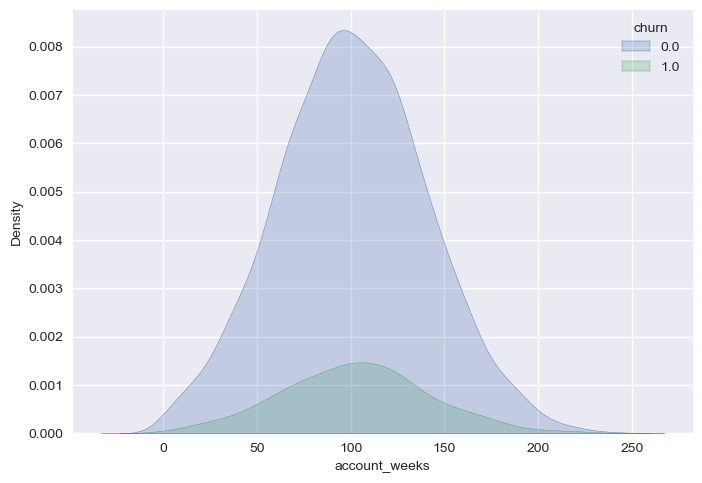

In [12]:
sns.kdeplot(data=telecom_data, x='account_weeks', hue='churn', fill=True)
plt.show()

Распределение переменной количества недель, в течение которого клиент имел активный счет, ничем не отличается от нормального
в независимости от факта оттока.

### **contract_renewal**

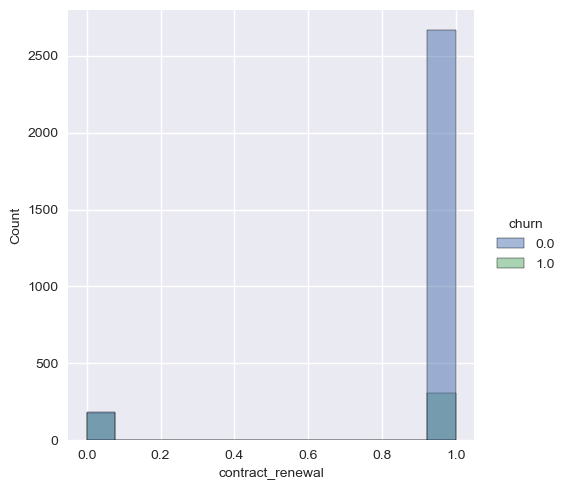

In [13]:
sns.displot(data=telecom_data, x='contract_renewal', hue='churn')
plt.show()

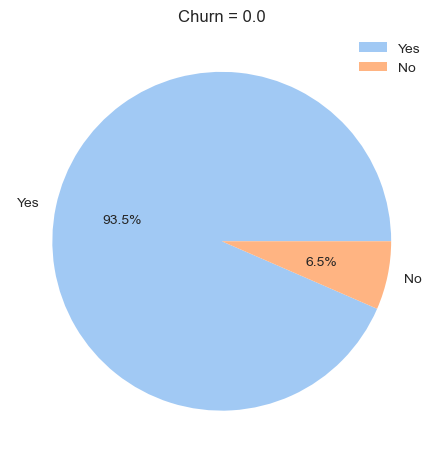

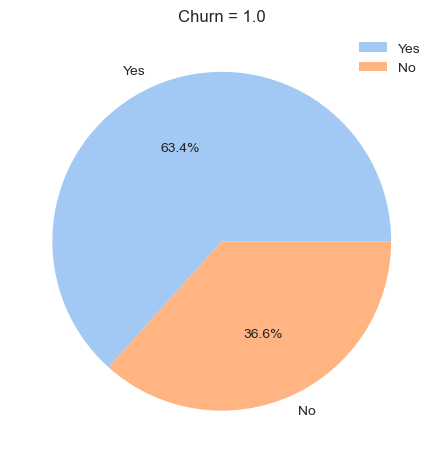

In [14]:
colors = sns.color_palette('pastel')[0:2]
for i in telecom_data['churn'].unique():
    plt.pie(telecom_data.query(f"churn=={i}")['contract_renewal'].value_counts(), labels = ['Yes', 'No'], colors=colors, autopct='%1.1f%%')
    plt.title(f'Churn = {i}')
    plt.legend()
    plt.show()

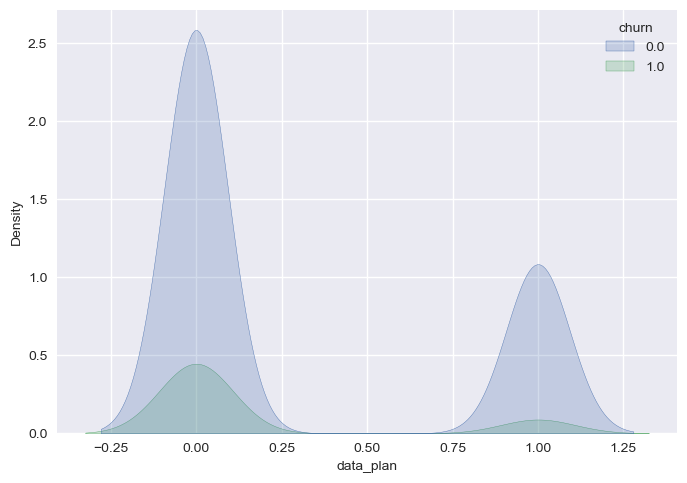

In [15]:
sns.kdeplot(data=telecom_data, x='data_plan', hue='churn', fill=True)
plt.show()

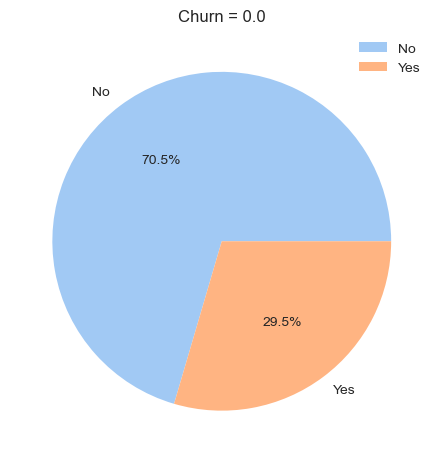

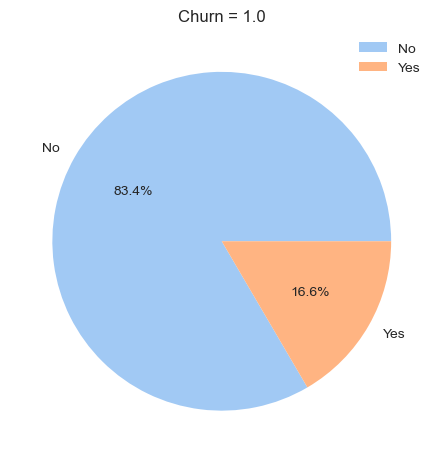

In [16]:
for i in telecom_data['churn'].unique():
    plt.pie(telecom_data.query(f"churn=={i}")['data_plan'].value_counts(), labels = ['No', 'Yes'], colors=colors, autopct='%1.1f%%')
    plt.title(f'Churn = {i}')
    plt.legend()
    plt.show()

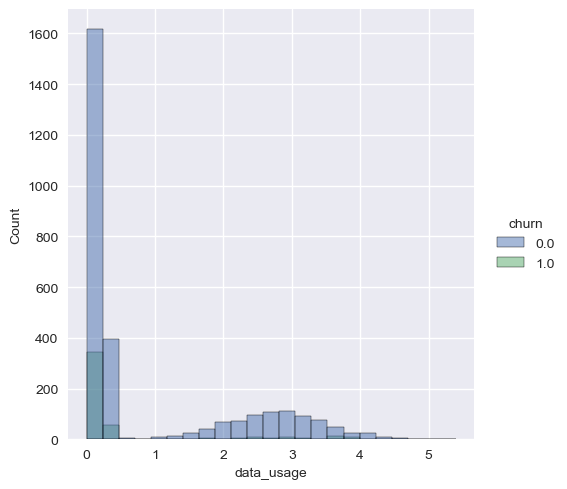

In [17]:
sns.displot(data=telecom_data, x='data_usage', hue='churn')
plt.show()

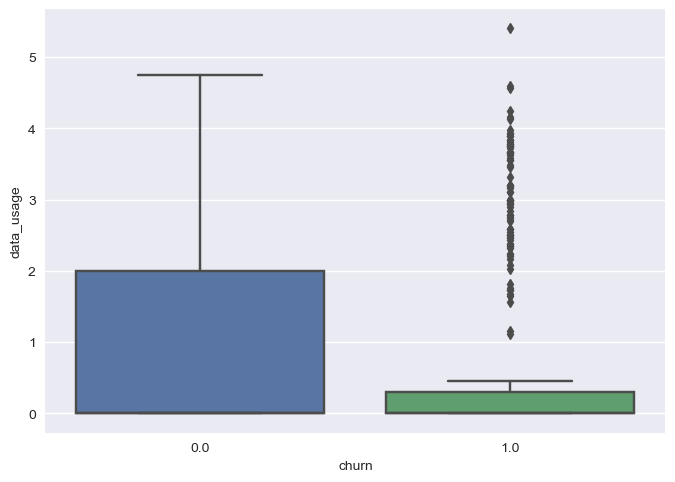

In [18]:
sns.boxplot(data=telecom_data, x='churn', y='data_usage')
plt.show()

In [19]:
telecom_data['data_usage_gt_0'] = np.where(telecom_data['data_usage'] > 0, 1, 0)

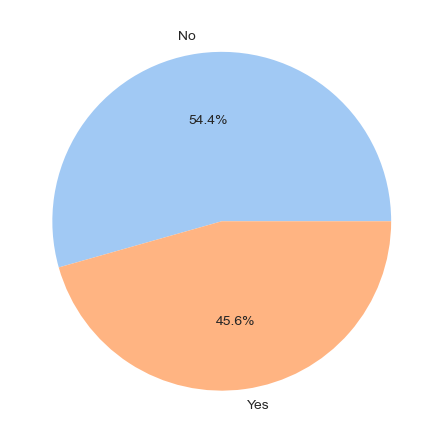

In [20]:
plt.pie(telecom_data['data_usage_gt_0'].value_counts(), labels = ['No', 'Yes'], colors=colors, autopct='%1.1f%%')
plt.show()

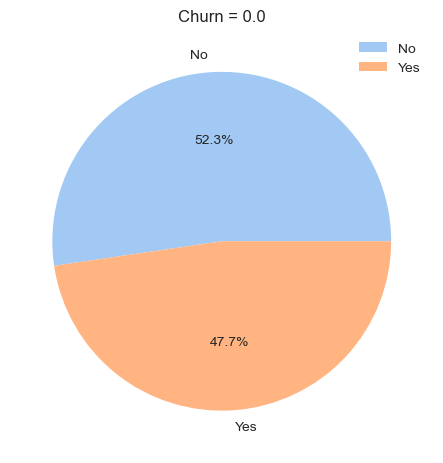

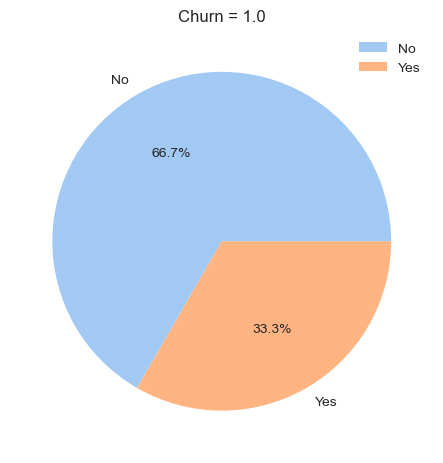

In [21]:
for i in telecom_data['churn'].unique():
    plt.pie(telecom_data.query(f"churn=={i}")['data_usage_gt_0'].value_counts(), labels = ['No', 'Yes'], colors=colors, autopct='%1.1f%%')
    plt.title(f'Churn = {i}')
    plt.legend()
    plt.show()

In [22]:
telecom_data.drop(['data_usage_gt_0'], axis=1, inplace=True)

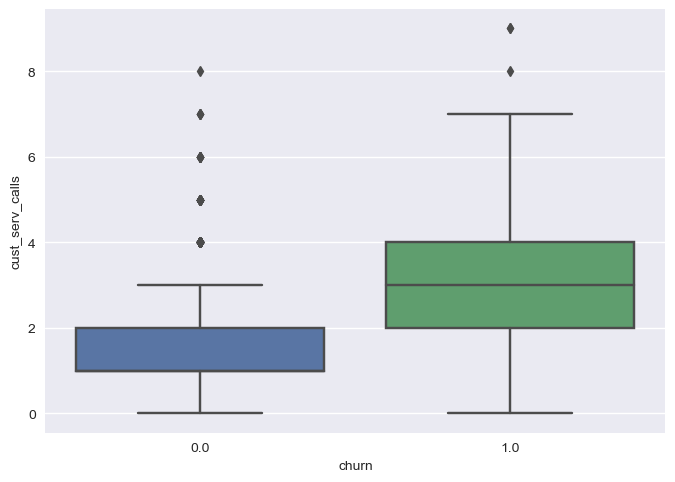

In [23]:
sns.boxplot(data=telecom_data, x='churn', y='cust_serv_calls')
plt.show()

In [24]:
for i in telecom_data['churn'].unique():
    print(f'\nChurn={i}\n',telecom_data.query(f"churn=={i}")['cust_serv_calls'].describe())


Churn=0.0
 count    2850.000000
mean        1.449825
std         1.163883
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: cust_serv_calls, dtype: float64

Churn=1.0
 count    483.000000
mean       3.194617
std        1.590758
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: cust_serv_calls, dtype: float64


In [25]:
telecom_data.query("churn==0")['cust_serv_calls'].quantile(0.95)

3.0

In [26]:
telecom_data['cust_serv_calls'] = np.where(telecom_data['cust_serv_calls'] > 3, 1, 0)

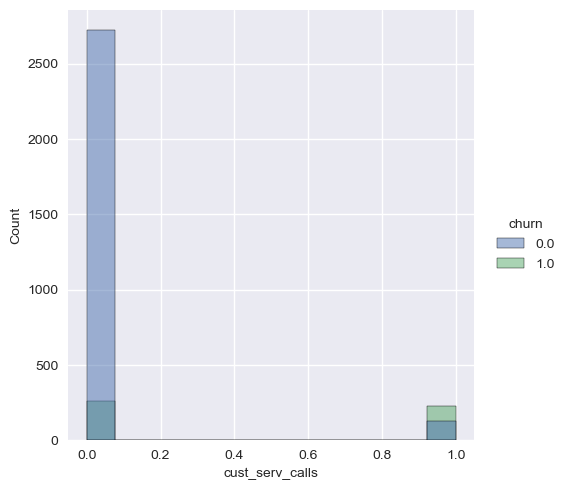

In [27]:
sns.displot(data=telecom_data, x='cust_serv_calls', hue='churn')
plt.show()

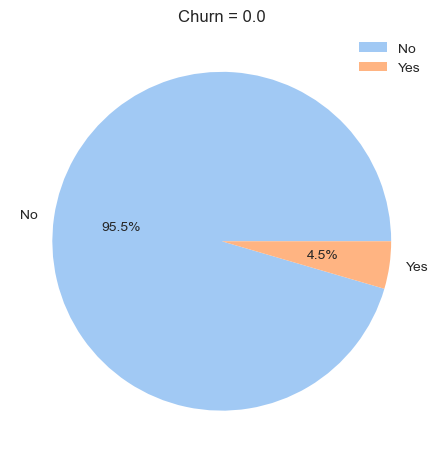

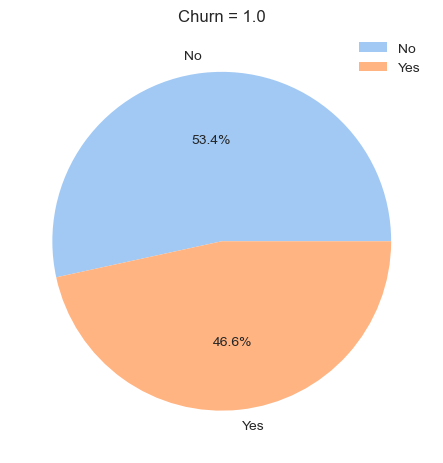

0.48051055204184745

In [28]:
for i in telecom_data['churn'].unique():
    plt.pie(telecom_data.query(f"churn=={i}")['cust_serv_calls'].value_counts(), labels = ['No', 'Yes'], colors=colors, autopct='%1.1f%%')
    plt.title(f'Churn = {i}')
    plt.legend()
    plt.show()
pearsonr(telecom_data['cust_serv_calls'], telecom_data['churn'])[0]

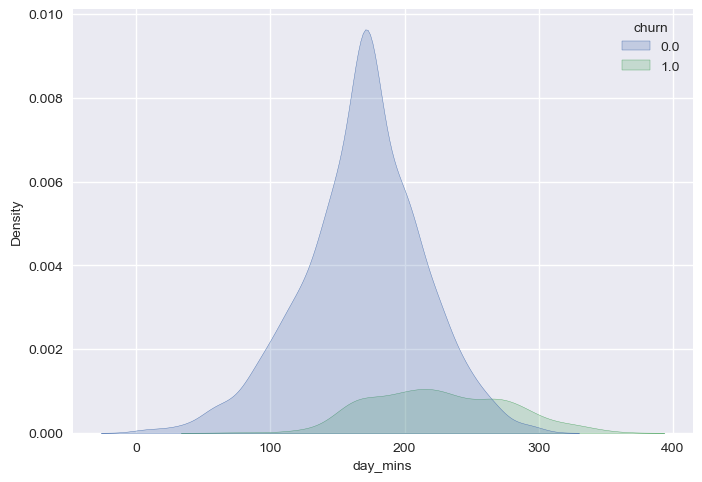

In [29]:
sns.kdeplot(data=telecom_data, x='day_mins', hue='churn', fill=True)
plt.show()

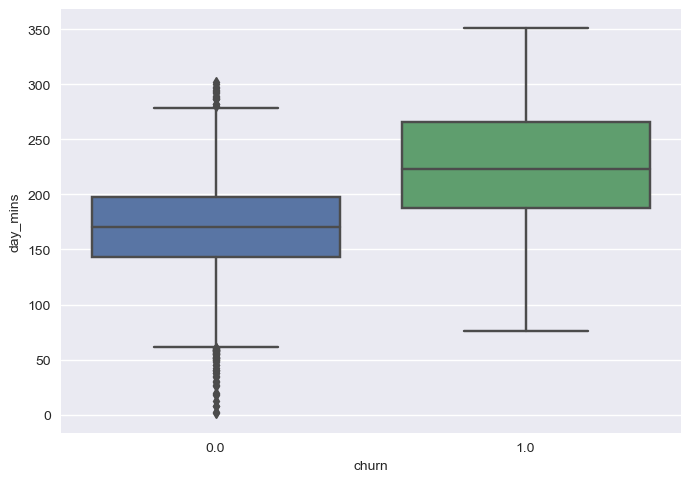

Churn=0.0: 170.6
Churn=1.0: 223.2


In [30]:
sns.boxplot(data=telecom_data, x='churn', y='day_mins')
plt.show()
for i in telecom_data['churn'].unique():
    print(f'Churn={i}:',telecom_data.query(f"churn=={i}")['day_mins'].median())

In [31]:
for i in telecom_data['churn'].unique():
    print(f'\nChurn={i}\n',telecom_data.query(f"churn=={i}")['day_mins'].describe())


Churn=0.0
 count    2850.000000
mean      168.599832
std        45.098688
min         1.000000
25%       142.825000
50%       170.600000
75%       197.300000
max       302.600000
Name: day_mins, dtype: float64

Churn=1.0
 count    483.000000
mean     225.595827
std       49.271913
min       76.000000
25%      187.950000
50%      223.200000
75%      265.950000
max      350.800000
Name: day_mins, dtype: float64


In [32]:
for i in telecom_data['churn'].unique():
    print(f'Churn={i}:',telecom_data.query(f"churn=={i}")['day_mins'].quantile(0.05))

Churn=0.0: 89.59
Churn=1.0: 155.11


In [33]:
alpha = 0.05
stat, p = mannwhitneyu(telecom_data.query("churn==0")['day_mins'], telecom_data.query("churn==1")['day_mins'])
if p < alpha:
    print('Отвергаем H0.')
else:
    print('не получилось отвергнуть H0.')

Отвергаем H0.


In [34]:
pearsonr(telecom_data['day_mins'], telecom_data['churn'])[0]

0.4018986740527961

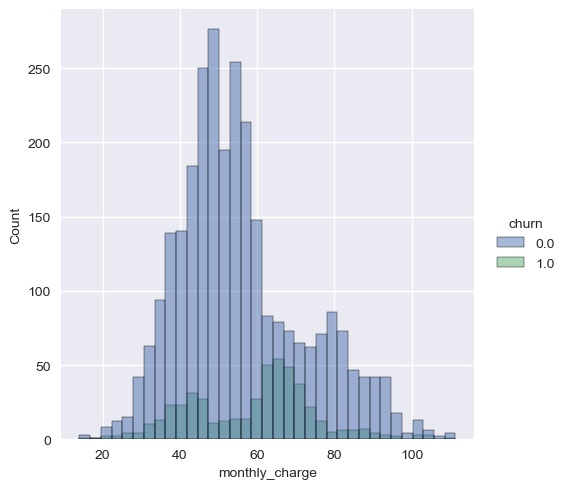

In [35]:
sns.displot(data=telecom_data, x='monthly_charge', hue='churn')
plt.show()

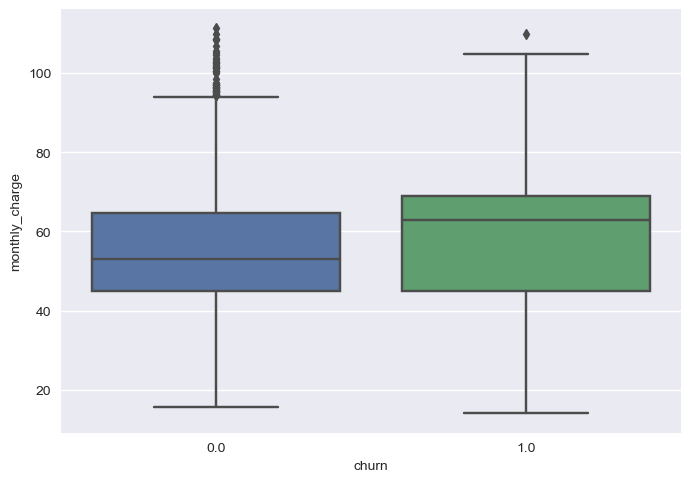

In [36]:
sns.boxplot(data=telecom_data, x='churn', y='monthly_charge')
plt.show()

In [37]:
for i in telecom_data['churn'].unique():
    print(f'\nChurn={i}\n',telecom_data.query(f"churn=={i}")['monthly_charge'].describe())


Churn=0.0
 count    2850.000000
mean       55.816246
std        16.439011
min        15.700000
25%        45.000000
50%        53.000000
75%        64.675000
max       111.300000
Name: monthly_charge, dtype: float64

Churn=1.0
 count    483.000000
mean      59.190062
std       16.065479
min       14.000000
25%       45.000000
50%       63.000000
75%       69.000000
max      110.000000
Name: monthly_charge, dtype: float64


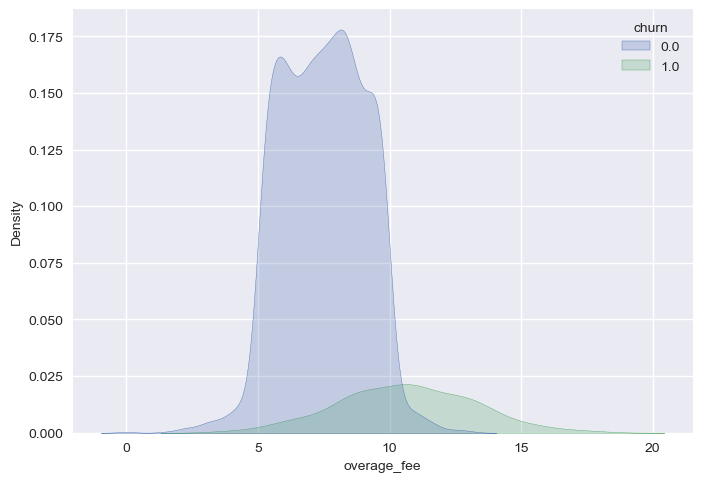

In [38]:
sns.kdeplot(data=telecom_data, x='overage_fee', hue='churn', fill=True)
plt.show()

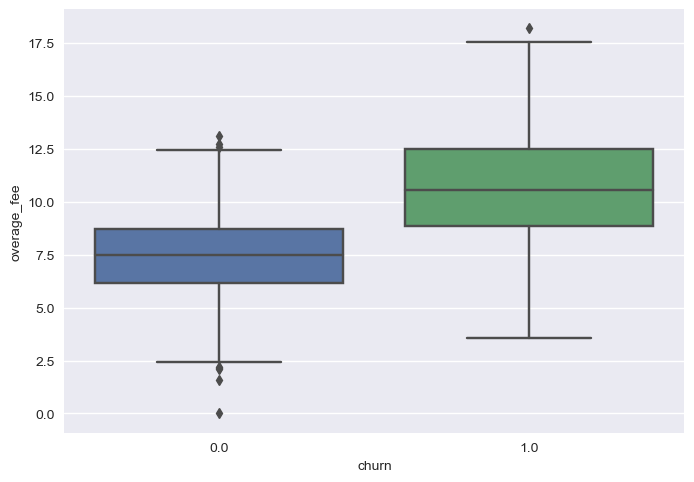

In [39]:
sns.boxplot(data=telecom_data, x='churn', y='overage_fee')
plt.show()

In [40]:
for i in telecom_data['churn'].unique():
    print(f'\nChurn={i}\n',telecom_data.query(f"churn=={i}")['overage_fee'].describe())


Churn=0.0
 count    2850.000000
mean        7.466898
std         1.593665
min         0.000000
25%         6.170000
50%         7.490000
75%         8.720000
max        13.090000
Name: overage_fee, dtype: float64

Churn=1.0
 count    483.000000
mean      10.623085
std        2.586433
min        3.550000
25%        8.860000
50%       10.570000
75%       12.475000
max       18.190000
Name: overage_fee, dtype: float64


In [41]:
telecom_data.query("churn==0")['overage_fee'].quantile(0.95)

9.83

In [42]:
telecom_data['overage_fee_gt_9_83'] = np.where(telecom_data['overage_fee'] > 9.83, 1, 0)

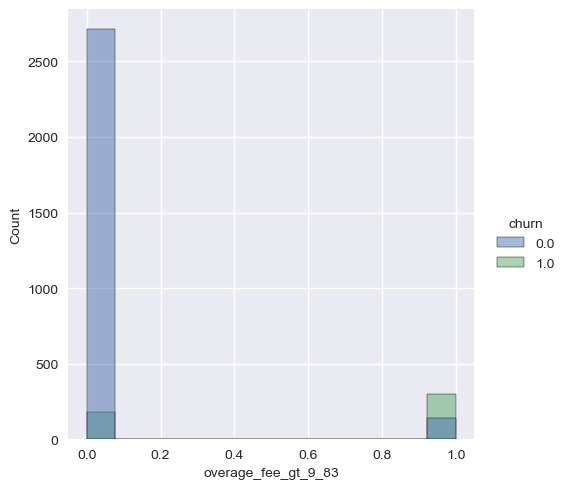

In [43]:
sns.displot(data=telecom_data, x='overage_fee_gt_9_83', hue='churn')
plt.show()

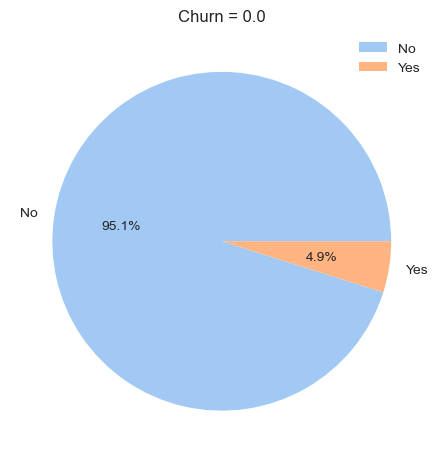

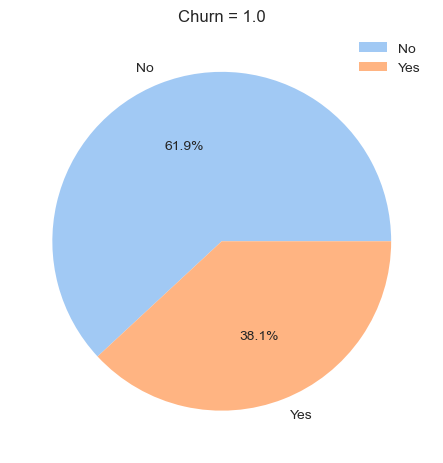

In [44]:
for i in telecom_data['churn'].unique():
    plt.pie(telecom_data.query(f"churn=={i}")['overage_fee_gt_9_83'].value_counts(), labels = ['No', 'Yes'], colors=colors,
            autopct='%1.1f%%')
    plt.title(f'Churn = {i}')
    plt.legend()
    plt.show()

In [45]:
alpha = 0.05
stat, p = mannwhitneyu(telecom_data.query("churn==0")['overage_fee'], telecom_data.query("churn==1")['overage_fee'])
if p < alpha:
    print('Отвергаем H0.')
else:
    print('не получилось отвергнуть H0.')

Отвергаем H0.


In [46]:
pearsonr(telecom_data['overage_fee'], telecom_data['churn'])[0]

0.5313076475511271

In [47]:
telecom_data.drop(['overage_fee_gt_9_83'], axis=1, inplace=True)

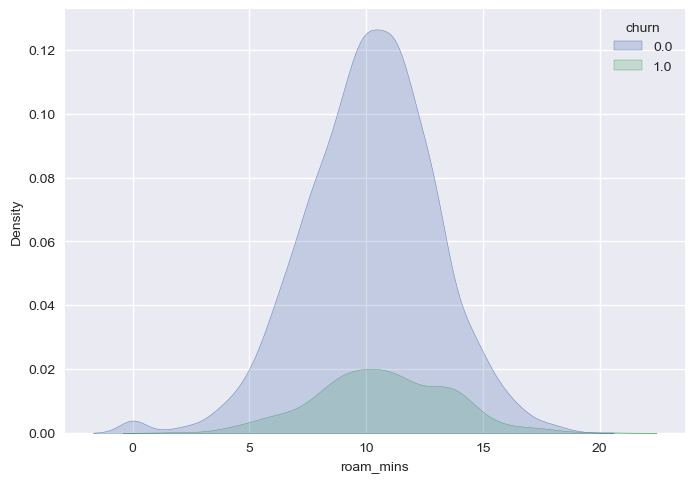

In [48]:
sns.kdeplot(data=telecom_data, x='roam_mins', hue='churn', fill=True)
plt.show()

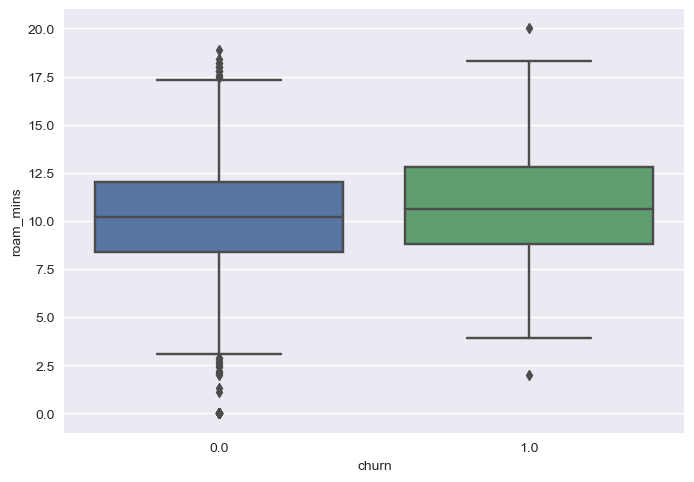

In [49]:
sns.boxplot(data=telecom_data, x='churn', y='roam_mins')
plt.show()

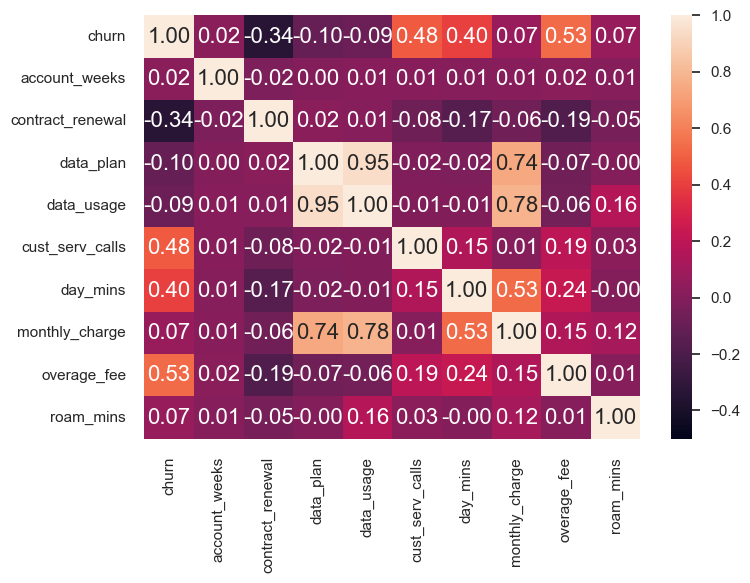

In [50]:
cm = telecom_data.corr()
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, fmt='.2f', vmin=-0.5, annot_kws={'size':16})
plt.show()

In [51]:
X = telecom_data.drop(['churn'], axis=1)
y = telecom_data['churn']

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

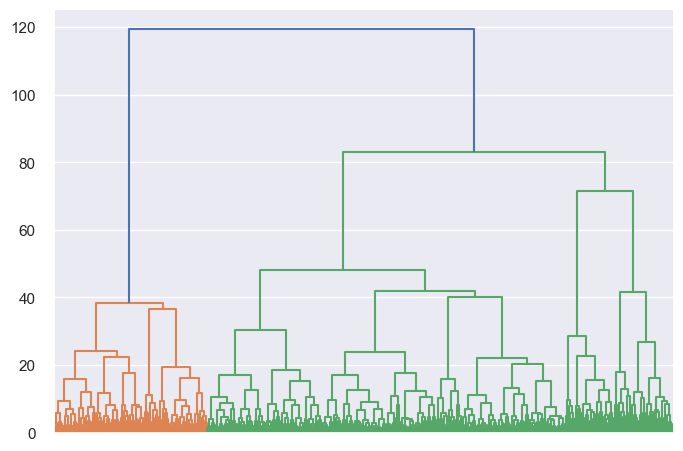

In [53]:
linked = linkage(X_scaled, method='ward')
dendrogram(linked, orientation='top', no_labels=True)
plt.show()

In [54]:
wcss=list()
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

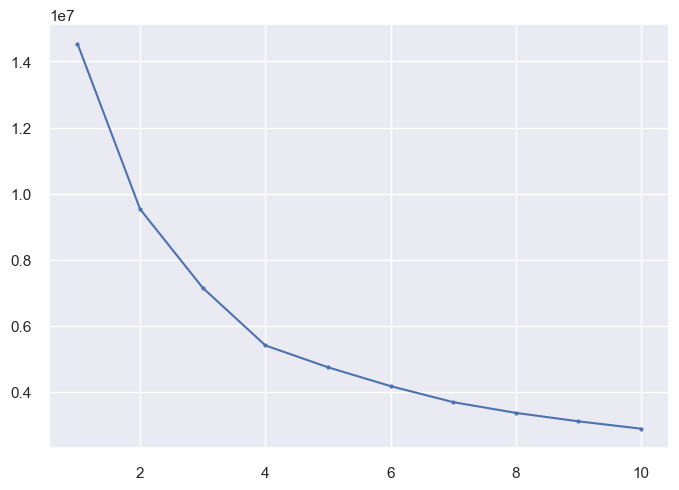

In [55]:
plt.plot(range(1,11),wcss, marker='.')
plt.show()

In [56]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
labels = kmeans.fit_predict(X_scaled)
telecom_data['clusters'] = labels
telecom_data.groupby(['clusters']).mean().sort_values('churn')

,churn,account_weeks,contract_renewal,data_plan,data_usage,cust_serv_calls,day_mins,monthly_charge,overage_fee,roam_mins
clusters,,,,,,,,,,
1,0.016631,100.363197,0.980687,0.006438,0.079399,0.003755,163.806701,46.718884,7.449989,10.145547
2,0.072707,101.152125,0.909396,1.000000,2.797852,0.087248,175.940369,76.469575,7.624978,10.360291
0,0.673043,103.203478,0.572174,0.027826,0.125270,0.467826,220.601609,56.030087,9.927130,10.343478


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [58]:
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [59]:
def train_model(model):
    model.fit(X_train_scaled,y_train)
    y_pred=model.predict(X_test_scaled)
    print(model,'\nAccuracy_score:',accuracy_score(y_test,y_pred),
         '\nPrecision_score:',precision_score(y_test,y_pred),
         '\nRecall_score:',recall_score(y_test,y_pred),
         '\nF1_score:',f1_score(y_test,y_pred),'\n')

In [60]:
for mod in [LogisticRegression(), RandomForestClassifier(), KNeighborsClassifier(), GaussianNB(), SVC(),
            DecisionTreeClassifier(), ExtraTreesClassifier(), RidgeClassifier(), GradientBoostingClassifier()]:
    train_model(mod)

LogisticRegression() 
Accuracy_score: 0.9652278177458034 
Precision_score: 0.8981481481481481 
Recall_score: 0.8434782608695652 
F1_score: 0.8699551569506726 

RandomForestClassifier() 
Accuracy_score: 0.973621103117506 
Precision_score: 0.918918918918919 
Recall_score: 0.8869565217391304 
F1_score: 0.9026548672566371 

KNeighborsClassifier() 
Accuracy_score: 0.9568345323741008 
Precision_score: 0.8691588785046729 
Recall_score: 0.808695652173913 
F1_score: 0.8378378378378378 

GaussianNB() 
Accuracy_score: 0.8992805755395683 
Precision_score: 0.5895953757225434 
Recall_score: 0.8869565217391304 
F1_score: 0.7083333333333334 

SVC() 
Accuracy_score: 0.9688249400479616 
Precision_score: 0.9158878504672897 
Recall_score: 0.8521739130434782 
F1_score: 0.8828828828828829 

DecisionTreeClassifier() 
Accuracy_score: 0.9544364508393285 
Precision_score: 0.8468468468468469 
Recall_score: 0.8173913043478261 
F1_score: 0.8318584070796462 

ExtraTreesClassifier() 
Accuracy_score: 0.96762589928057

In [61]:
clf = GradientBoostingClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
print('Accuracy_score:',accuracy_score(y_test,y_pred),
         '\nPrecision_score:',precision_score(y_test,y_pred),
         '\nRecall_score:',recall_score(y_test,y_pred),
         '\nF1_score:',f1_score(y_test,y_pred))

Accuracy_score: 0.9784172661870504 
Precision_score: 0.9292035398230089 
Recall_score: 0.9130434782608695 
F1_score: 0.9210526315789473


In [62]:
clf = GradientBoostingClassifier()
parameters = {
    "min_samples_split": [2,5,8,11,16,20],
    'min_samples_leaf': [1,3,6,9],
    'max_depth': [1,3,5,9,13],
    'max_features' : ['log2'],
    'learning_rate' : [0, 0.1, 0.15, 0.2, 0.5, 1],
    'n_estimators' : [50,100,150,200],
    'random_state' : [0]
    }
grid = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test_scaled)
print('Accuracy_score:',accuracy_score(y_test,y_pred),
         '\nPrecision_score:',precision_score(y_test,y_pred),
         '\nRecall_score:',recall_score(y_test,y_pred),
         '\nF1_score:',f1_score(y_test,y_pred))

Accuracy_score: 0.9844124700239808 
Precision_score: 0.9553571428571429 
Recall_score: 0.9304347826086956 
F1_score: 0.9427312775330396


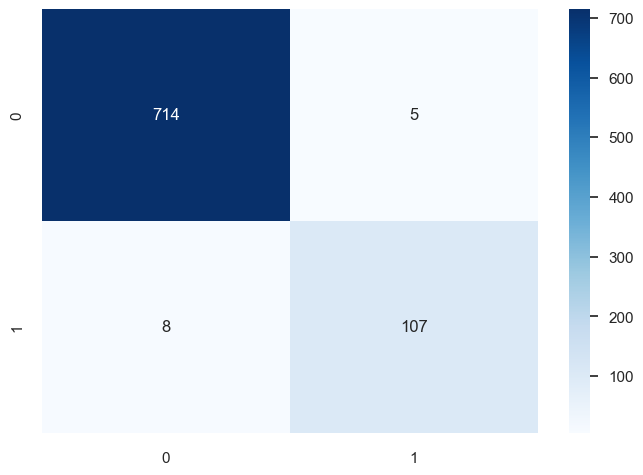

In [63]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.show()

In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       719
         1.0       0.96      0.93      0.94       115

    accuracy                           0.98       834
   macro avg       0.97      0.96      0.97       834
weighted avg       0.98      0.98      0.98       834



roc_auc_score: 0.9965410896776924


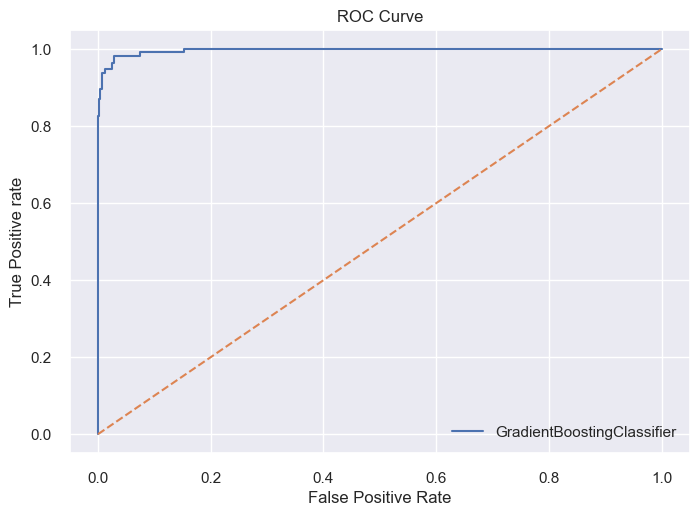

In [65]:
y_pred_prob = best_clf.predict_proba(X_test_scaled)
print('roc_auc_score:', roc_auc_score(y_test, y_pred_prob[:,1]))

fpr, tpr, thresh = roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='-', label='GradientBoostingClassifier')
plt.plot(p_fpr, p_tpr, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()